In [0]:
# pip install nltk

In [0]:
# pip install beautifulsoup4

In [0]:
import pyspark
import itertools
from collections import defaultdict
from pyspark.sql import*
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as sf
from pyspark.sql.functions import*
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import IntegerType, FloatType, DataType, TimestampType, StringType, StructType, StructField
from pyspark.sql.functions import udf
from pyspark.sql.functions import sum
from pyspark.ml.feature import Tokenizer, RegexTokenizer
# from apache.spark.sql.expressions import UserDefinedFunction
conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)
from bs4 import BeautifulSoup

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Functions for preprocesssing data
def removePunc(word):
    punctuations = '''!()-[];:"'\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for char in word:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct


def parseHTML(doc):
    soup = BeautifulSoup(doc, 'html.parser')
    text = soup.get_text()

    return text

def splitWords(text):
    return text.split()

def removeStopWords(sentences):
    newSentences = []
    for word in sentences:
        if (word not in stopwords.words('english') and len(word)>4 and len(word) < 13):
            newSentences.append(word)
    return newSentences

In [0]:
# Function for importing the files
def loadFile(file_location):
    mySchema = StructType([ StructField("Id", IntegerType(), True),
                      StructField("PostTypeId", IntegerType(), True),
                      StructField("AcceptedAnswerId", IntegerType(), True),
                      StructField("ParentId", IntegerType(), True),
                       StructField("CreationDate", TimestampType(), True),
                       StructField("DeletionDat", TimestampType(), True),
                       StructField("Score", IntegerType(), True),
                       StructField("ViewCount", IntegerType(), True),
                       StructField("Body", StringType(), True),
                       StructField("OwnerUserId", IntegerType(), True),
                       StructField("OwnerDisplayName", StringType(), True),
                       StructField("LastEditorUserId", IntegerType(), True),
                       StructField("LastEditorDisplayName", StringType(), True),
                       StructField("LastEditDate", TimestampType(), True),
                       StructField("LastActivityDate", TimestampType(), True),
                       StructField("Title", StringType(), True),
                       StructField("Tags", StringType(), True),
                       StructField("AnswerCount", IntegerType(), True),
                       StructField("CommentCount", IntegerType(), True),
                       StructField("FavoriteCount", IntegerType(), True),
                       StructField("ClosedDate", TimestampType(), True),
                       StructField("CommunityOwnedDate", TimestampType(), True),
                       StructField("ContentLicense", StringType(), True)
                      ])

    # File location and type
    file_type = "csv"

    # CSV options
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    multiLine = "true"
    escape = "\""
    quote = "\""

    # The applied options are for CSV files. For other file types, these will be ignored.
    df = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .option("multiLine", multiLine) \
      .option("escape", escape) \
      .schema(mySchema) \
      .load(file_location)
    return df


In [0]:
# Importing the Files
df_ML = loadFile("/FileStore/tables/SO_ML.csv")
df_SEC = loadFile("/FileStore/tables/SO_Security.csv")
df_SP = loadFile("/FileStore/tables/SO_Spark.csv")

In [0]:
# Making word lists for each file from the 'body' column
def makeWordList(df):
    rows = df.select('Body').collect()
    wordList = []
    for i in rows:
        wordList.append(i[0])
    return wordList

wordList_ML = makeWordList(df_ML)
wordList_SEC = makeWordList(df_SEC)
wordList_SP = makeWordList(df_SP)

In [0]:
# Parsing Html and removing punctuation
def parseWordList(wordList):
    parsedList = []
    for characters in wordList:
        parsed = parseHTML(characters)
        punctRem = removePunc(parsed)
        parsedList.append(punctRem)
    # Splitting text into words and removing stopwords and words smaller than 3 characters
#     del parsedList[10000:]
    splitText = []
    for words in parsedList:
        splitW = splitWords(words)
        stopWordsRmvd = removeStopWords(splitW)
        splitText.append(stopWordsRmvd)
    return splitText
splitText_ML = parseWordList(wordList_ML)
splitText_SEC = parseWordList(wordList_SEC)
splitText_SP = parseWordList(wordList_SP)

In [0]:
# Splitting the text into a list of words
def genSuperList(splitText):
    superList = []
    for wordList in splitText:
        for word in wordList:
            word = word.lower()
            superList.append(word)
    return superList
superList_ML = genSuperList(splitText_ML)
superList_SEC = genSuperList(splitText_SEC)
superList_SP = genSuperList(splitText_SP)

In [0]:
# Count the word frequency of each file
def countWordFreq(text):
    newDict = defaultdict(int)
    for i in text:
        newDict[i] += 1
    newDict2 = sorted(newDict.items(), key=lambda x:x[1], reverse = True)
    return newDict2

In [0]:
# Generating sorted list of words for each file
sortedSuperList_ML = countWordFreq(superList_ML)
sortedSuperList_SEC = countWordFreq(superList_SEC)
sortedSuperList_SP = countWordFreq(superList_SP)
# print(sortedSuperList_SP)

In [0]:
# Top 10 most frequent keywords in each dataset/file
def genFreqLists(dict):
    del dict[10:]
    title = []
    freq = []
    for t in dict:
        title.append(t[0])
        freq.append(t[1])
    return title, freq
titlesML, valuesML = genFreqLists(sortedSuperList_ML)
print ("ML Word: {}, \nML Frequency: {}".format(titlesML, valuesML))

titlesSEC, valuesSEC = genFreqLists(sortedSuperList_SEC)
print ("SEC Word: {}, \nSEC Frequency: {}".format(titlesSEC, valuesSEC))

titlesSP, valuesSP = genFreqLists(sortedSuperList_SP)
print ("SP Word: {}, \nSP Frequency: {}".format(titlesSP, valuesSP))


ML Word: ['model', 'import', 'using', 'training', 'error', 'return', 'dataset', 'output', 'input', 'train'], 
ML Frequency: [58147, 52688, 33142, 27607, 25120, 24968, 20331, 20132, 19202, 17934]
SEC Word: ['using', 'security', 'server', 'would', 'password', 'application', 'access', 'users', 'public', 'string'], 
SEC Frequency: [29032, 28736, 25252, 22588, 19727, 19614, 18689, 14929, 14382, 13273]
SP Word: ['spark', 'using', 'error', 'import', 'string', 'dataframe', 'column', 'following', 'class', 'table'], 
SP Frequency: [68281, 32581, 32486, 27922, 27080, 22895, 17824, 15433, 15140, 14569]


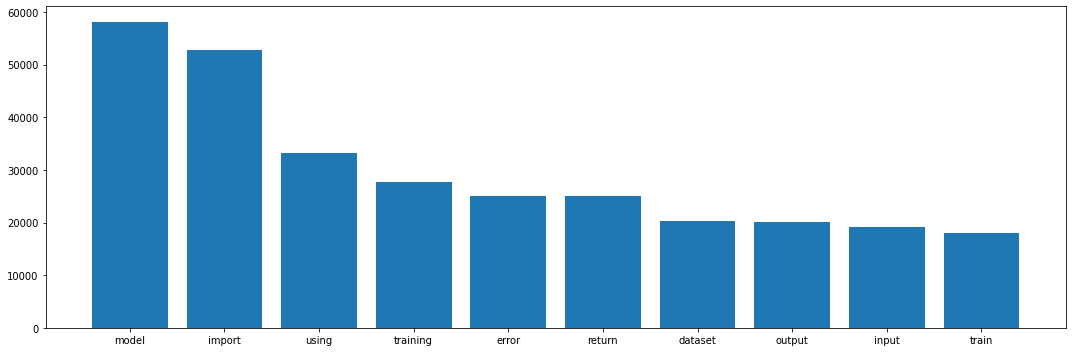

In [0]:
# Plotting the bar chart
from matplotlib import pyplot as plt

def printBarChart(title, value):
    plt.rcParams["figure.figsize"] = [15.00, 5.0]
    plt.rcParams["figure.autolayout"] = True
    plt.bar(title, value)
    plt.show()

printBarChart(titlesML, valuesML)

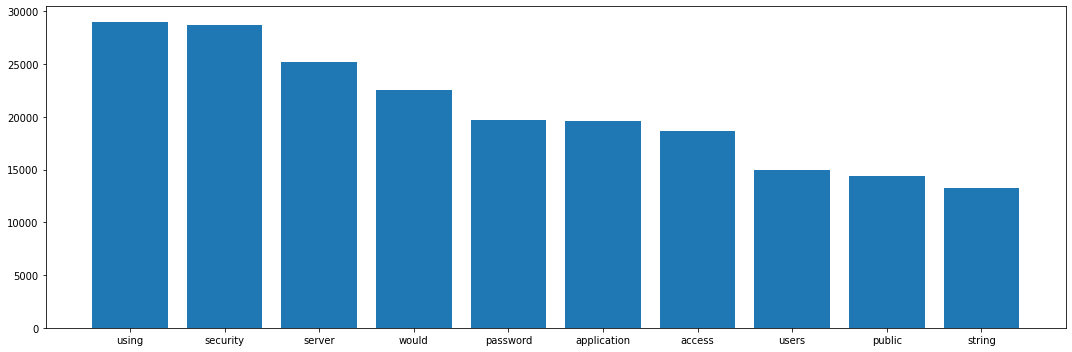

In [0]:
# Printing for security
printBarChart(titlesSEC, valuesSEC)

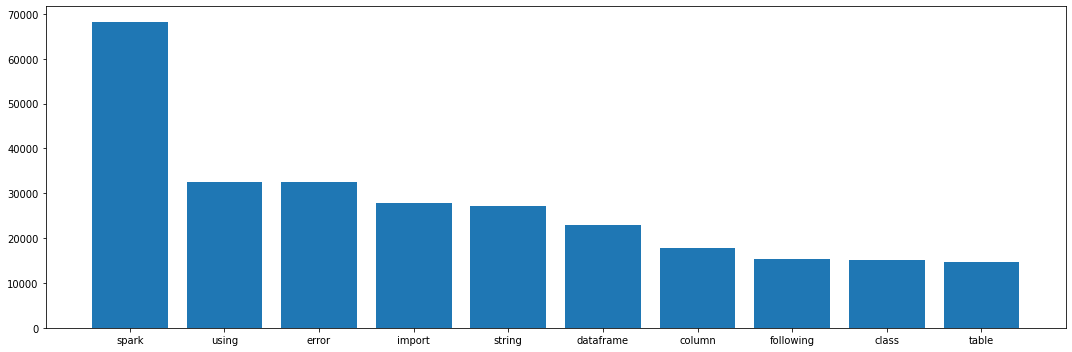

In [0]:
# Printing for Spark
printBarChart(titlesSP, valuesSP)

In [0]:
# Top 30 keywords in all 3 files

def countWordFreqTotal(text1, text2, text3):
    newDict = defaultdict(int)
    for i in text1:
        newDict[i] += 1
    for j in text2:
        newDict[j] += 1
    for k in text3:
        newDict[k] += 1
    newDict2 = sorted(newDict.items(), key=lambda x:x[1], reverse = True)
    return newDict2

def genFreqListsTotal(dict):
    del dict[30:]
    title = []
    freq = []
    for t in dict:
        title.append(t[0])
        freq.append(t[1])
    return title, freq


In [0]:
# Generating dictionary with sorted words in all documents
sortedSuperListTotal = countWordFreqTotal(superList_ML, superList_SEC, superList_SP)

# Getting top 30 words
titlesTotal, valuesTotal = genFreqListsTotal(sortedSuperListTotal)
print ("Top 30 Words: {}, \nML Frequency: {}".format(titlesTotal, valuesTotal))

Top 30 Words: ['using', 'import', 'spark', 'error', 'model', 'would', 'return', 'string', 'class', 'function', 'trying', 'following', 'output', 'value', 'input', 'application', 'server', 'problem', 'security', 'training', 'example', 'could', 'dataset', 'dataframe', 'tried', 'values', 'create', 'column', 'method', 'access'], 
ML Frequency: [94755, 85245, 69382, 67850, 63395, 52295, 47165, 43829, 37722, 35986, 35817, 35453, 32716, 32410, 31023, 30588, 30099, 29170, 28970, 28653, 27351, 26918, 26599, 26414, 26027, 24529, 24144, 23972, 23254, 22168]


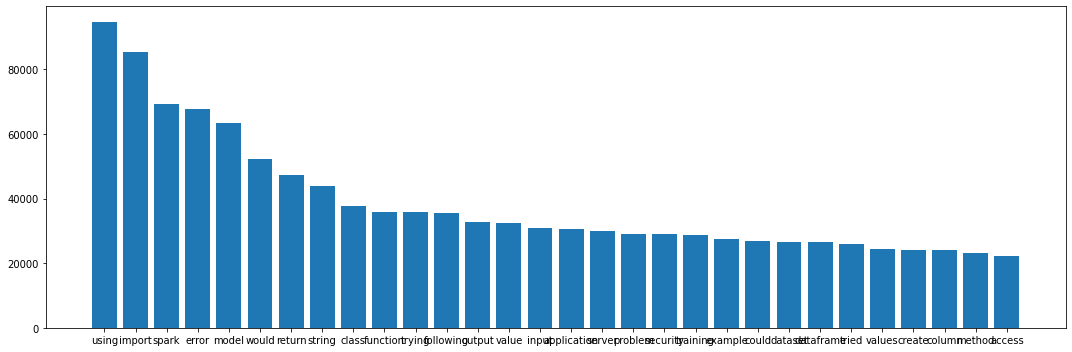

In [0]:
printBarChart(titlesTotal, valuesTotal)

In [0]:
# counting the number of accepted answers
def countAnswers(data):
    df = data.na.fill(0)
    rows = df.select('AcceptedAnswerId').collect()
    count = 0
    for j in rows:
        if (j[0] == 0):
            count = count + 1
    return count
num_ML = countAnswers(df_ML)
num_SEC = countAnswers(df_SEC)
num_SP = countAnswers(df_SP)
print("Number of accepted answers are as follows: \nMachine Learning: {}, \nSecurity: {}, \nSpark: {}".format(num_ML, num_SEC, num_SP))

Number of accepted answers are as follows: 
Machine Learning: 28533, 
Security: 23736, 
Spark: 28323


In [0]:
# calculating posts created by year
def noOfPosts(data):
    listOfDates = []
    df_date = data.select(date_format("CreationDate", 'yyyy/MM/dd').alias('date')).collect()
    for i in df_date:
        listOfDates.append(i[0][:4])
    date_freq = countWordFreq(listOfDates)
    return date_freq

freqOfDates_ML = noOfPosts(df_ML)
freqOfDates_SEC = noOfPosts(df_SEC)
freqOfDates_SP = noOfPosts(df_SP)

In [0]:
# Top 10 most frequent keywords in ML dataset
def genFreqLists2(dict):
    title = []
    freq = []
    for t in dict:
        title.append(t[0])
        freq.append(t[1])
    return title, freq
titles_ML, freq_ML = genFreqLists2(freqOfDates_ML)
titles_SEC, freq_SEC = genFreqLists2(freqOfDates_SEC)
titles_SP, freq_SP = genFreqLists2(freqOfDates_SP)
print ("For Machine Learning, \nYears: {}, \nFreq: {} \nFor Security, \nYears: {}, \nFreq: {} \nFor Spark, \nYears: {}, \nFreqOfEntries: {}".format(titles_ML, freq_ML, titles_SEC, freq_SEC, titles_SP, freq_SP))


For Machine Learning, 
Years: ['2020', '2018', '2017', '2019', '2021', '2016', '2022', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008'], 
Freq: [7808, 6908, 6776, 6548, 5172, 4720, 4285, 2618, 1731, 1500, 1032, 504, 295, 94, 9] 
For Security, 
Years: ['2013', '2012', '2011', '2014', '2015', '2010', '2016', '2017', '2020', '2009', '2019', '2018', '2022', '2021', '2008'], 
Freq: [5528, 5452, 5303, 5167, 4440, 3955, 3612, 3339, 2787, 2563, 2182, 2070, 1562, 1405, 635] 
For Spark, 
Years: ['2019', '2017', '2016', '2020', '2015', '2018', '2022', '2021', '2014', '2013', '2012', '2011'], 
FreqOfEntries: [8770, 8285, 7985, 7092, 5102, 4401, 3986, 3112, 1203, 61, 2, 1]


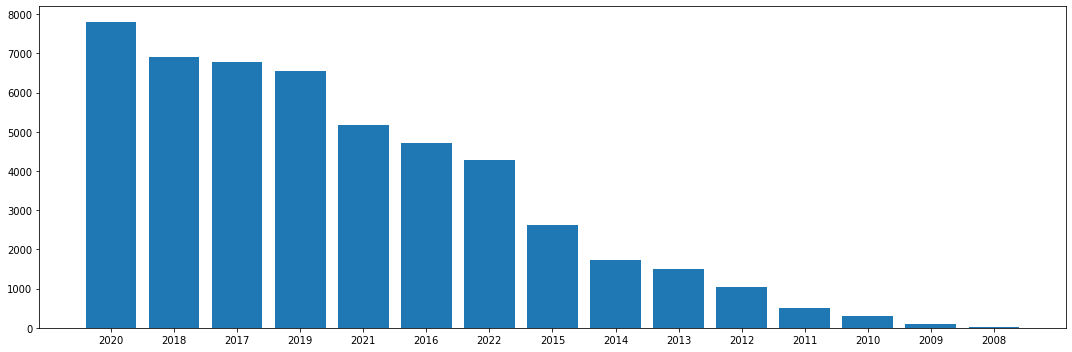

In [0]:
# Plotting 10 most frequent words for machine Learning

def printBarChart2(titles, values):
    plt.rcParams["figure.figsize"] = [15.00, 5.0]
    plt.rcParams["figure.autolayout"] = True
    plt.bar(titles, values)
    plt.show()

printBarChart2(titles_ML,freq_ML)



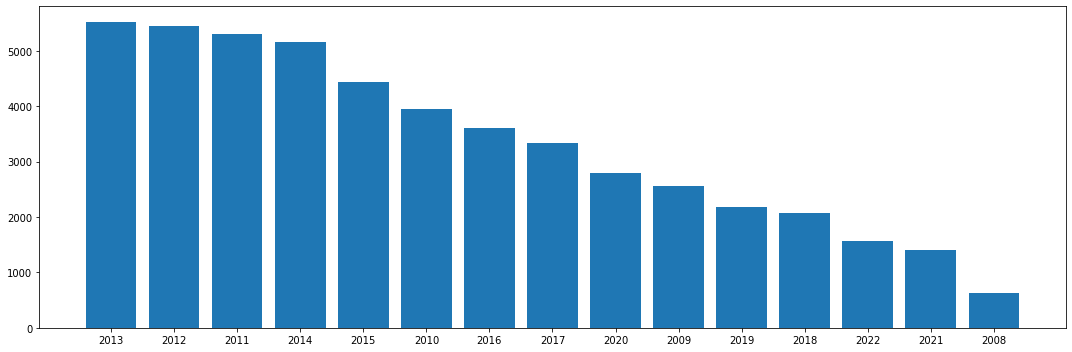

In [0]:
# Plotting 10 most frequent words for security 
printBarChart2(titles_SEC,freq_SEC)

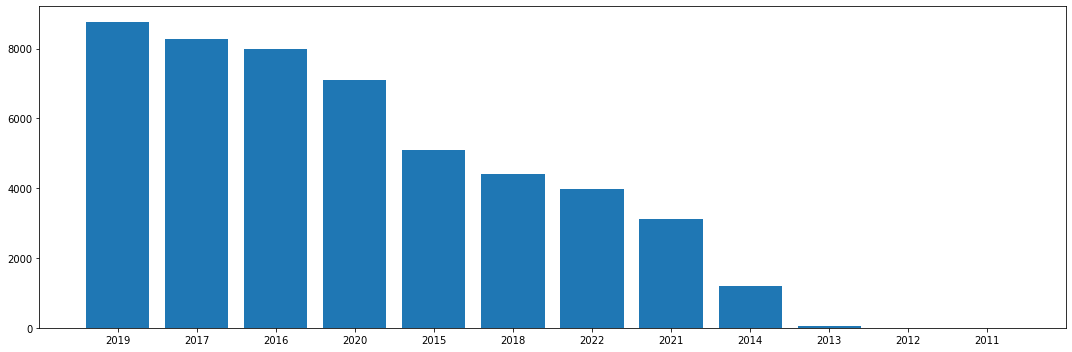

In [0]:
# Plotting 10 most frequent words for Spark
printBarChart2(titles_SP,freq_SP)